# Classifying values as anomalous

Sometimes we’re happy with the type that ptype infers for a column, but discover that it has incorrectly treated as legitimate some values which we know to be anomalies. We can remedy this by extending the set of values that ptype treats as anomalies, and then rerunning the analysis. We illustrate this with a toy example.

In [1]:
# Preamble to run notebook in context of source package.
# NBVAL_IGNORE_OUTPUT
import sys
sys.path.insert(0, '../')

### Toy Example

In [2]:
import pandas as pd

x = ['Jack', 'Joe', 'James', 'error']
column = 'name'

df = pd.DataFrame(x, dtype='str', columns=[column])
df

,name
0,Jack
1,Joe
2,James
3,error


In [3]:
from ptype.Ptype import Ptype

ptype = Ptype()
schema = ptype.schema_fit(df)
schema.show()

,name
type,string
normal values,"[Jack, James, Joe, error]"
missing values,[]
anomalous values,[]


In [4]:
an_values = ptype.get_additional_an_values()

an_values.extend(["error"])
ptype.set_additional_an_values(an_values)

schema = ptype.schema_fit(df)
schema.show()

,name
type,string
normal values,"[Jack, James, Joe]"
missing values,[]
anomalous values,[error]


# Classifying "anomalous" values as normal
### Real-world Data

The analytical task is to estimate the effort that a software project would take.

In [5]:
import pandas as pd
from ptype.Ptype import Ptype

df = pd.read_csv("../../../ptype-dmkd/combined_datasets/usp05.csv", encoding="ISO-8859-1", dtype=str, keep_default_na=False)
df.head()

,ID,ObjType,Effort,FunctPercent,IntComplx,DataFile,DataEn,DataOut,UFP,Lang,Tools,AppExpr,DBMS,Method,AppType
0,101,FT,2.5,"0.00,0.80,0.10,0.10,0.00,0.00,0.00",5,18,94,NULL,NULL,sql,mySQLweb,4,mysql,NULL,BC/S
1,102,FT,2.5,"0.00,0.70,0.00,0.10,0.10,0.10,0.00",5,9,240,NULL,NULL,sql,mySQLweb,4,mysql,NULL,BC/S
2,114,FT,2,"0.10,0.30,0.10,0.30,0.00,0.00,0.20",2,9,15,0,0,"html,_php,_sql,_proprietary","notepad,_webforms",4,mysql,"SA,SD",BC/S
3,115,FT,2,"0.10,0.30,0.10,0.30,0.00,0.00,0.20",2,9,15,0,0,"html,_php,_sql,_proprietary","notepad,_webforms",4,mysql,"SA,SD",BC/S
4,116,FT,3.5,"0.10,0.30,0.10,0.30,0.00,0.00,0.20",2,9,15,0,0,"html,_php,_sql,_proprietary","notepad,_webforms",5,mysql,"SA,SD",BC/S


In [6]:
features = ["Lang", "AppExpr"]
target = ["Effort"]

df = df[features+target]
df.head()

,Lang,AppExpr,Effort
0,sql,4,2.5
1,sql,4,2.5
2,"html,_php,_sql,_proprietary",4,2
3,"html,_php,_sql,_proprietary",4,2
4,"html,_php,_sql,_proprietary",5,3.5


In [7]:
ptype = Ptype()
schema = ptype.schema_fit(df)
schema.show()

,Lang,AppExpr,Effort
type,string,float,float
normal values,"[HTML, HTML,_PHP, HTML,_PHP,_Javascript,_SQL, ...","[1, 2, 3, 3.5, 4, 5]","[0.5, 1, 1.5, 10, 100, 11, 12, 15, 16, 2, 2.5,..."
missing values,[NULL],[],[]
anomalous values,"[C#,_ASP.Net_SQL]",[],[]


In [8]:
df2 = schema.transform(df)
df2

,Lang,AppExpr,Effort
0,sql,4.0,2.5
1,sql,4.0,2.5
2,"html,_php,_sql,_proprietary",4.0,2.0
3,"html,_php,_sql,_proprietary",4.0,2.0
4,"html,_php,_sql,_proprietary",5.0,3.5
...,...,...,...
198,"HTML,_PHP,_SQL",3.0,3.0
199,"HTML,_PHP,_SQL",3.0,2.0
200,"HTML,_PHP,_SQL",3.0,5.0
201,"HTML,_PHP,_SQL",3.0,3.0


In [9]:
df2.isna().sum()

Lang       13
AppExpr     0
Effort      0
dtype: int64

### Convert to categorical variables 

In [10]:
df3 = pd.concat([df2, pd.get_dummies(df2["Lang"])], axis=1)
df3.drop(['Lang'], inplace=True, axis=1)
df3

,AppExpr,Effort,HTML,"HTML,_PHP","HTML,_PHP,_Javascript,_SQL","HTML,_PHP,_Oracle","HTML,_PHP,_SQL","Html,_JavaScript",MySQL,PHP,...,"PHP,_SQL,_HTML","PHP,_SQL,_JavaScript","PHP,_SQL,_SH","Php,_Html,_JavaScript","Php,_Html,_Sql,_JavaScript",SQL,"html,_php,_sql,_proprietary",javascript,"php,_sql",sql
0,4.0,2.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,4.0,2.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4.0,2.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4.0,2.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,5.0,3.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,3.0,3.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199,3.0,2.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200,3.0,5.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
201,3.0,3.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


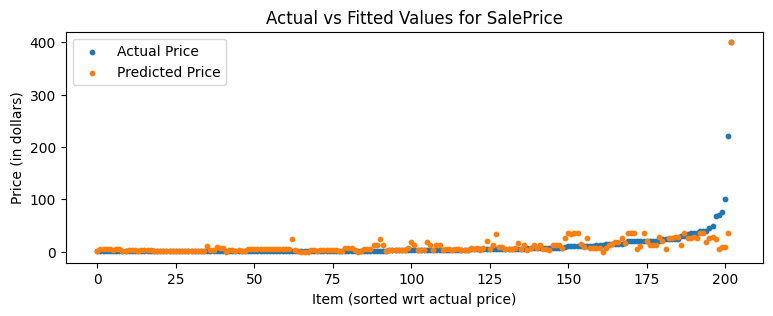

In [11]:
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcdefaults()

lm = LinearRegression()

features = set(list(df3.columns)).difference(set(["Effort"]))
X = df3[features].values
y = df3[target].values

lm.fit(X, y)
y_hat = lm.predict(X)

def scatter_plot(y, y_hat):
    plt.figure(figsize=(9, 3))

    sorted_indices = sorted(range(len(y)),key=y.__getitem__)
    plt.scatter(range(len(y)), y[sorted_indices], label='Actual Price', s=10)
    plt.scatter(range(len(y)), y_hat[sorted_indices], label='Predicted Price', s=10)

    plt.title('Actual vs Fitted Values for SalePrice')
    plt.xlabel('Item (sorted wrt actual price)')
    plt.ylabel('Price (in dollars)')
    plt.legend()
    plt.show()

scatter_plot(y, y_hat)

In [12]:
### 

In [13]:
str_alphabet = ptype.get_string_alphabet()

str_alphabet.extend(["#"])
ptype.set_string_alphabet(str_alphabet)

schema = ptype.schema_fit(df)
schema.show()
# to-do: should we consider making this column specific rather than a global list
# this again can be done similar to how it is handled in pandas.read_csv which is 
# keep_default_na=False, na_values={'species':['']}

,Lang,AppExpr,Effort
type,string,float,float
normal values,"[C#,_ASP.Net_SQL, HTML, HTML,_PHP, HTML,_PHP,_...","[1, 2, 3, 3.5, 4, 5]","[0.5, 1, 1.5, 10, 100, 11, 12, 15, 16, 2, 2.5,..."
missing values,[NULL],[],[]
anomalous values,[],[],[]


In [14]:
df2 = schema.transform(df)
df3 = pd.concat([df2, pd.get_dummies(df2["Lang"])], axis=1)
df3.drop(['Lang'], inplace=True, axis=1)
df3

,AppExpr,Effort,"C#,_ASP.Net_SQL",HTML,"HTML,_PHP","HTML,_PHP,_Javascript,_SQL","HTML,_PHP,_Oracle","HTML,_PHP,_SQL","Html,_JavaScript",MySQL,...,"PHP,_SQL,_HTML","PHP,_SQL,_JavaScript","PHP,_SQL,_SH","Php,_Html,_JavaScript","Php,_Html,_Sql,_JavaScript",SQL,"html,_php,_sql,_proprietary",javascript,"php,_sql",sql
0,4.0,2.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,4.0,2.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4.0,2.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4.0,2.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,5.0,3.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,3.0,3.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
199,3.0,2.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
200,3.0,5.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
201,3.0,3.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


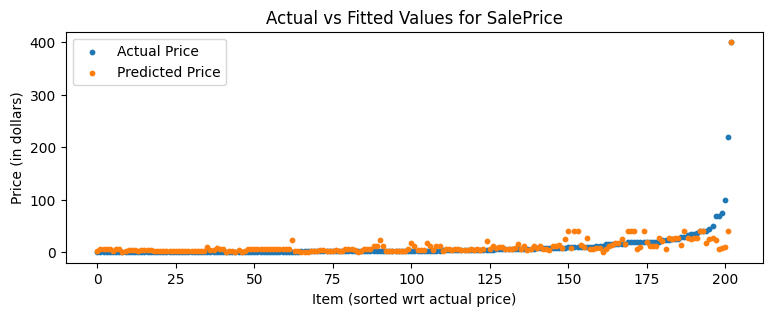

In [15]:
lm = LinearRegression()

features = set(list(df3.columns)).difference(set(["Effort"]))
X = df3[features].values
y = df3[target].values

lm.fit(X, y)
y_hat = lm.predict(X)

def scatter_plot(y, y_hat):
    plt.figure(figsize=(9, 3))

    sorted_indices = sorted(range(len(y)),key=y.__getitem__)
    plt.scatter(range(len(y)), y[sorted_indices], label='Actual Price', s=10)
    plt.scatter(range(len(y)), y_hat[sorted_indices], label='Predicted Price', s=10)

    plt.title('Actual vs Fitted Values for SalePrice')
    plt.xlabel('Item (sorted wrt actual price)')
    plt.ylabel('Price (in dollars)')
    plt.legend()
    plt.show()

scatter_plot(y, y_hat)